In [1]:
using LinearAlgebra
using FFTW
using Plots
include("../topology.jl")
include("../main.jl")
using .topology
using .main
plotlyjs()

Plots.PlotlyJSBackend()

In [2]:
const Pr = 0.71
const nu = 1/180/Pr
const dt = 1e-4


const Nx = 400
const Nz = 129

const kx = 1
const ky = 0

0

In [3]:
const domain = [2*pi, pi, 2]
const dims = [Nx, 16, Nz-2]
coords = topology.generate_coords(domain, dims; center=true, stretch=false)

x = coords.x
z = [-1 .* coords.z[1]; coords.z; 2*domain[3]-coords.z[end]]


const dx = x[2] - x[1]
const dz = z[2] - z[1]
const Lx = domain[1]

xx = x .+ z'.*0
zz = x .* 0 .+ z'

u = zz .* ( 2 .- zz)
v = zz .* 0
w = zz .* 0;

In [4]:
function explicit_solver(u, v, w, T)
    adv = zeros(Float64, (Nx, Nz))
    adv[:, 2:end-1] .= u[:, 2:end-1] .* (circshift(T[:, 2:end-1],[-1, 0]) .- circshift(T[:, 2:end-1],[1, 0]))./dx./2

    diff = zeros(Float64, (Nx, Nz))
    diff[:, 2:end-1] .= nu .*( circshift(T[:, 2:end-1],[-1,0]) .- 2 .*T[:, 2:end-1] .+ circshift(T[:, 2:end-1],[1,0]))./dx./dx .+ 
    nu .*(T[:, 3:end] .- 2 .*T[:, 2:end-1] .+ T[:, 1:end-2] ) ./dz./dz

    T_out = zeros(Float64, (Nx, Nz))
    T_out .= T .- dt .* adv .+ dt .* diff

    return T_out
end

explicit_solver (generic function with 1 method)

In [5]:
function implicit_solver(u, v, w, T)
    # Modified Wavenumber k = sin(kx * dx/2) * 2 /dx    
    mkx = zeros(Float64, (Nx));
    for ki in range(1, Nx)
        kkx = 2*pi/Lx*(ki-1);
        mkx[ki] = 2*abs(sin(0.5*kkx*dx))/dx;
    end


    RHS = zeros(Float64, (Nx, Nz));
    RHS .= T - dt .* u .* (circshift(T,[-1, 0]) .- circshift(T,[1, 0]))./dx./2;

    RHS_hat = zeros(ComplexF64, (Nx, Nz));
    for k in range(1, Nz)
        RHS_hat[:, k] = fft(RHS[:, k]);
    end

    D2 = diagm(0 => -2*ones((Nz)), 1 => ones((Nz-1)), -1 => ones((Nz-1)));
    D2 .= D2/dz/dz;


    T_hat = zeros(ComplexF64, (Nx, Nz));
    for ki in range(1, Nx)
        D = diagm(ones((Nz))) - dt*nu * (D2 - diagm(ones((Nz))) * mkx[ki]^2 );
        D[1, 1] = 1;
        D[1, 2] = 1;
        D[end, end-1] = 1;
        D[end, end] = 1;

        T_hat[ki, :] = D\RHS_hat[ki, :];
    end
    

    for k in range(1, Nz)
        T[:, k] = real(ifft(T_hat[:, k]));
    end

    return T
end

implicit_solver (generic function with 1 method)

In [6]:
function half_implicit_solver(u, v, w, T)
    # Modified Wavenumber k = sin(kx * dx/2) * 2 /dx    
    mkx = zeros(Float64, (Nx));
    for ki in range(1, Nx)
        kkx = 2*pi/Lx*(ki-1);
        mkx[ki] = 2*abs(sin(0.5*kkx*dx))/dx;
    end


    RHS = zeros(Float64, (Nx, Nz));
    RHS[:, 2:end-1] .= T[:, 2:end-1] - dt .* u[:, 2:end-1] .* (circshift(T[:, 2:end-1],[-1, 0]) .- circshift(T[:, 2:end-1],[1, 0]))./dx./2 +
        0.5 * dt * nu .*( circshift(T[:, 2:end-1],[-1,0]) .- 2 .*T[:, 2:end-1] .+ circshift(T[:, 2:end-1],[1,0]))./dx./dx .+ 
        0.5 * dt * nu .*(T[:, 3:end] .- 2 .*T[:, 2:end-1] .+ T[:, 1:end-2] ) ./dz./dz;

    RHS_hat = zeros(ComplexF64, (Nx, Nz));
    for k in range(1, Nz)
        RHS_hat[:, k] = fft(RHS[:, k]);
    end

    D2 = diagm(0 => -2*ones((Nz)), 1 => ones((Nz-1)), -1 => ones((Nz-1)));
    D2 .= D2/dz/dz;


    T_hat = zeros(ComplexF64, (Nx, Nz));
    for ki in range(1, Nx)
        D = diagm(ones((Nz))) - 0.5 * dt*nu * (D2 - diagm(ones((Nz))) * mkx[ki]^2 );
        D[1, 1] = 1;
        D[1, 2] = 1;
        D[end, end-1] = 1;
        D[end, end] = 1;

        T_hat[ki, :] = D\RHS_hat[ki, :];
    end
    

    for k in range(1, Nz)
        T[:, k] = real(ifft(T_hat[:, k]));
    end

    return T
end

half_implicit_solver (generic function with 1 method)

In [7]:
A = Array{ComplexF64, 2}(undef, Nz-2, Nz-2)
B = Array{ComplexF64, 2}(undef, Nz-2, Nz-2)

for k in range(2, Nz-1)
    T = zeros(Float64, (Nx, Nz))
    T_out = zeros(Float64, (Nx, Nz))

    T[:, k] .=  sin.(kx .* x)

    # input = [fft(T[:, k], 1)[kx+1] for k in range(1, Nz)]
    A[:, k-1] .= fft(T[:, 2:end-1], 1)[kx+1, :]


    T_out .= half_implicit_solver(u, v, w, T)

    # output = [fft(RHS[:, k], 1)[kx+1] for k in range(1, Nz)]
    B[:, k-1] .= fft(T_out[:, 2:end-1], 1)[kx+1, :]
end

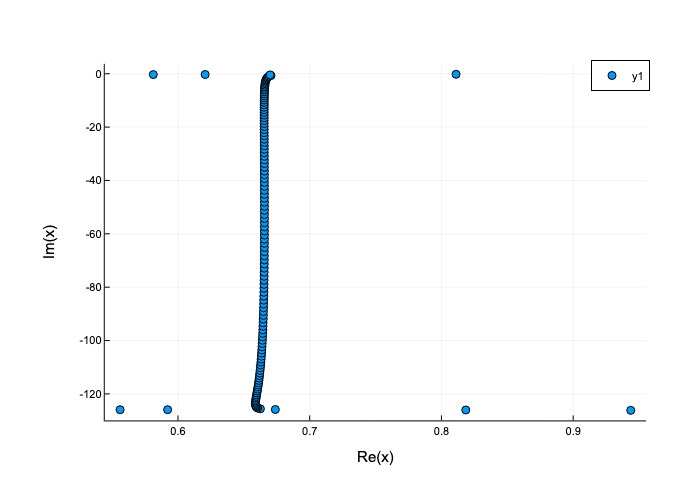

In [11]:
F = eigen(B,A)
omega = 1im.*log.(F.values)./dt
scatter(omega)

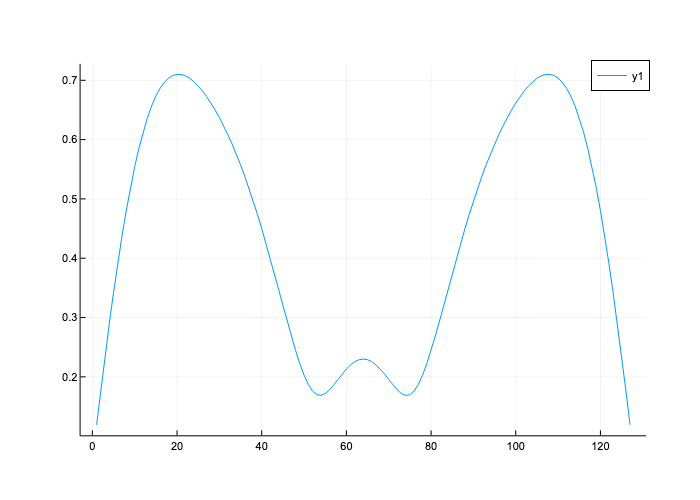

In [12]:
plot(abs.(F.vectors[:, 4]))

In [10]:
fname = "/Users/user/Documents/Projects/python_util/data/scalar_LST_matlab_linux.mat"

"/Users/user/Documents/Projects/python_util/data/scalar_LST_matlab_linux.mat"

In [16]:
include("../../julia_utils/lst.jl")
using .lst_scalar

lst = generate_LST(384, 2)

Main.lst_scalar.lst_result(Main.lst_scalar.chebyshev_basis([1.0 1.0 … 1.0 1.0; 1.0 0.9999663589326276 … -0.9999663589326276 -1.0; … ; 1.0 -0.9999663589326276 … -0.9999663589326273 1.0; 1.0 -1.0 … 1.0 -1.0], [0.0 1.0 … 145924.0 146689.0; 0.0 1.0 … 382.00000000003456 4.433786671143025e-12; … ; 0.0 1.0 … -381.99999999792703 -2.032948032137938e-9; 0.0 1.0 … -145924.0 146689.0], [0.0 0.0 … 7.097889284e9 7.172505344e9; 0.0 0.0 … 2.174478255910663e9 2.1802439530996423e9; … ; 0.0 0.0 … 2.174478255910572e9 -2.180243953099546e9; 0.0 0.0 … 7.097889284e9 -7.172505344e9], [0.0 0.0 … 2.07144800864256e14 2.1041978927692797e14; 0.0 0.0 … 9.612628284071489e13 9.721186558164142e13; … ; 0.0 0.0 … -9.61262828407124e13 9.721186558163903e13; 0.0 0.0 … -2.07144800864256e14 2.1041978927692797e14], [0.0 0.0 … 4.3179333740154184e18 4.409196384448544e18; 0.0 0.0 … 2.4273624174535224e18 2.4707403965968394e18; … ; 0.0 0.0 … 2.427362417453479e18 -2.4707403965967923e18; 0.0 0.0 … 4.3179333740154184e18 -4.40919638444

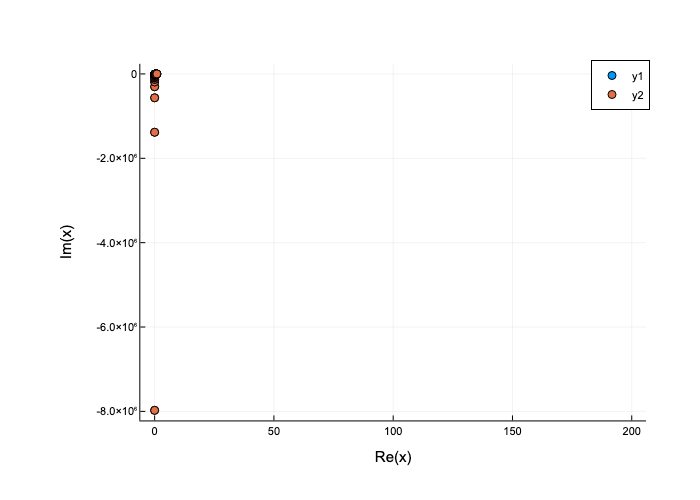

In [17]:
scatter(omega)
scatter!(1im .* lst.F.values)